- 프로젝트명 : 물순환시스템 설비예지보전
- 분석자 : 백종환
- 일자 : 2023년 8월 2일 ~ 8월 8일

# Water Circulation System 설비 예지 보전
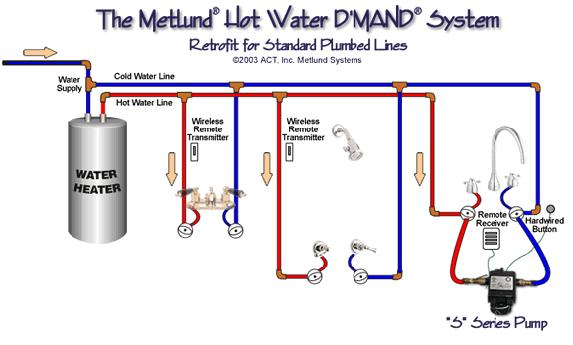

- 문제이해하기, 데이터 훑어보기
- 문제해결 프로세스 정의 : 문제해결 기획
- 수행내용
    - Data 전처리 및 EDA
    - 시계열 센서 데이터 분석
    - 이상탐지 모델링

In [2]:
# 경고메시지 무시할 때
import warnings
warnings.filterwarnings('ignore')

## 문제이해하기, 데이터 훑어보기

### 가상 시나리오  
- A사는 Water Circulation System을 운영하는 유지보수 업체다.  
- 사업이 확장됨에 따라 많은 고객을 대상으로 Water Circulation System을 설치하고 있다.  
- Water Circulation System은 한번 고장이 나면 심각한 피해를 발생시키기 때문에 사전에 이상징후를 발견하고 조치를 통해 고장을 사전에 방지하는 활동이 매우 중요하다.  
- A사는 사업이 확장됨에 따라 관리해야할 업체들이 증가하고 있고, 고장이 발생한다면 사업에 큰 지장을 초래하기 때문에 이상진단 모델을 통해서 사전 유지보수 활동을 전개해나가고자 한다.

### 데이터 구성

* 시계열 센서 데이터 (Water Circulation System)
* 데이터 명세  

|Column|Description|
|:---|:---|
|datetime|시간|
|Accelerometer1RMS|진동 가속도1|
|Accelerometer2RMS|진동 가속도2|
|Current |전기모터 암페어(Ampere)|
|Pressure|워터 펌프 후 루프의 압력(Bar) |
|Temperature|엔진의 온도(섭씨 온도)|
|Thermocouple|순환 루프에서 유체의 온도(섭씨 온도)|
|Voltage|전기 모터의 전압(Volt)|
|Volume Flow RateRMS|루프 내부의 유체의 순환 유량(Liter/min)|
|anomaly|이상여부|
|changepoint|변경점 여부|

    - 와우 "이상여부"가 있다. label 존재 !!

In [28]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 읽어오기, 구분자가 ,가 아니고 ; 이네요.
df = pd.read_csv("물순환설비데이터.csv", sep=";")
df

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 16:16:30,0.027545,0.041127,0.673506,0.054711,67.8345,24.3164,240.513,32.0000,0.0,0.0
1,2020-03-09 16:16:31,0.027997,0.039100,0.772264,0.054711,67.8704,24.3279,229.523,32.0000,0.0,0.0
2,2020-03-09 16:16:32,0.028418,0.038872,0.675520,0.054711,67.7882,24.3261,242.708,32.0000,0.0,0.0
3,2020-03-09 16:16:33,0.027625,0.039366,0.566279,-0.273216,67.7918,24.3323,229.709,32.0000,0.0,0.0
4,2020-03-09 16:16:34,0.027484,0.041854,1.292170,0.054711,67.7368,24.3250,242.746,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1058,2020-03-09 16:36:26,0.026954,0.040592,1.200720,0.054711,67.6181,24.2314,245.247,32.0000,0.0,0.0
1059,2020-03-09 16:36:27,0.027371,0.040530,1.318550,-0.273216,67.8733,24.2234,243.576,32.0000,0.0,0.0
1060,2020-03-09 16:36:28,0.027557,0.039432,1.068740,0.054711,67.6173,24.2315,239.957,31.9603,0.0,0.0
1061,2020-03-09 16:36:29,0.027456,0.038556,1.127880,0.054711,67.9696,24.2272,221.236,31.0409,0.0,0.0


* 위 데이터를 보니, 초당 수집되는 데이터인 것 같네요. ^^
* 그리고 나머지는 데이터는 숫자이네요. 


## 문제해결 프로세스 기획 (데이터분석 전에 반드시 수행되어야 하는 단계)

1) 문제정의
- 사업 확장으로 인한 관리 Point 증가에 따른 운영 및 유지보수 인력 부족
- Water Circulation System 고장으로 인한 리스크 발생 우려

2) 기대효과 : 기대효과 낮으면 굳이 고급인력을 활용해서 데이터분석을 할 필요가 없다.
- 이상진단 시스템을 통한 사전 유지보수를 통해 고장 발생으로 인한 리스크(비용, 신뢰도 등등) 감소
- 이상진단 솔루션 제공(ex. AI 기반 이상탐지 알고리즘)을 통한 추가 고객 유치
- 기존 고객의 충성도 증가

3) 해결방안
- 모델링을 통한 이상진단 시스템 구축 및 운영
    - Data 전처리 및 EDA 
    - 시계열 센서 데이터 분석 
    - 이상탐지 모델링 

4) 성과측정 (모델의 성능인 정확도 90%? 이것은 성과가 아님. 문제정의에 맞는 성과가 측정되어야 함)
- 이상진단 시스템 활용 전/후 고장 발생률 비교 (Main KPI)
- 이상진단 솔루션 운영 전/후 신규 고객 증가 및 기존 고객 만족도 조사

5) 현업적용을 위해서는 ...
- 이상진단 모델 생성
- 실시간 데이터 수집 체계 구축
- 실시간 이상 진단 모델 실행 및 결과값 출력
- 결과값 기반 모니터링 시스템(이상진단 대시보드) 운영


## Data 전처리 및 EDA

### Data 전처리  
- 수집된 데이터의 기본 정보들을 확인해서 데이터에 문제가 있는지 확인하는 단계  

  (1) Data shape(모양, row/column 개수) 확인
  
  (2) Data type 확인 : 숫자, 문자 등 확인, '123' : 이건 문자죠 !
  
  (3) Null(NaN)값 확인 (※ 빈 값의 Data)
  
  (4) Outlier 확인 (※ 정상적인 범주를 벗어난 Data)  - 이상탐지에서는 outlier를 찾는 거라 제거하면 안되지만, 그런데 전압데이터인데 음수라면 제거해야 함.

In [29]:
# Data 형태 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063 entries, 0 to 1062
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             1063 non-null   object 
 1   Accelerometer1RMS    1063 non-null   float64
 2   Accelerometer2RMS    1063 non-null   float64
 3   Current              1063 non-null   float64
 4   Pressure             1063 non-null   float64
 5   Temperature          1063 non-null   float64
 6   Thermocouple         1063 non-null   float64
 7   Voltage              1063 non-null   float64
 8   Volume Flow RateRMS  1063 non-null   float64
 9   anomaly              1063 non-null   float64
 10  changepoint          1063 non-null   float64
dtypes: float64(10), object(1)
memory usage: 91.5+ KB


In [30]:
# Null 값 확인
df.isna().sum()

datetime               0
Accelerometer1RMS      0
Accelerometer2RMS      0
Current                0
Pressure               0
Temperature            0
Thermocouple           0
Voltage                0
Volume Flow RateRMS    0
anomaly                0
changepoint            0
dtype: int64

In [31]:
# Outlier 확인, describe()는 수치형 데이터에 대해서만 동작함.
df.describe()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,0.027663,0.040037,1.195240,0.048541,67.895174,24.265096,229.924824,31.472275,0.313264,0.003763
std,0.000333,0.001086,7.113407,0.270689,0.695198,0.021573,13.259556,1.314535,0.464039,0.061256
min,0.026455,0.036972,0.394058,-0.929070,66.201900,24.217000,0.580776,28.040000,0.000000,0.000000
25%,0.027434,0.039276,0.753505,0.054711,67.412450,24.252950,223.570000,31.039050,0.000000,0.000000
50%,0.027674,0.040098,1.002720,0.054711,67.955000,24.267200,230.634000,32.000000,0.000000,0.000000
75%,0.027892,0.040828,1.194580,0.054711,68.515500,24.277450,236.960000,32.038900,1.000000,0.000000
max,0.028554,0.043122,232.734000,1.038490,69.098200,24.332300,254.125000,33.000000,1.000000,1.000000


In [32]:
# Outlier 확인(음수값), pressure
df[df['Pressure'] < 0]

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
3,2020-03-09 16:16:33,0.027625,0.039366,0.566279,-0.273216,67.7918,24.3323,229.709,32.0000,0.0,0.0
6,2020-03-09 16:16:37,0.027832,0.039037,0.785302,-0.273216,68.0941,24.3156,206.719,32.9627,0.0,0.0
10,2020-03-09 16:16:41,0.027365,0.040159,1.214350,-0.273216,68.0307,24.3237,217.917,32.0000,0.0,0.0
12,2020-03-09 16:16:43,0.027701,0.037805,1.127500,-0.273216,67.9973,24.3158,227.584,32.0000,0.0,0.0
13,2020-03-09 16:16:44,0.027992,0.038999,1.100170,-0.273216,67.8537,24.3254,229.871,32.0000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1040,2020-03-09 16:36:07,0.027159,0.041038,1.136500,-0.273216,67.4501,24.2403,213.065,32.0000,0.0,0.0
1042,2020-03-09 16:36:09,0.028116,0.041636,0.869275,-0.273216,67.4311,24.2304,238.981,32.0000,0.0,0.0
1048,2020-03-09 16:36:15,0.027833,0.041701,1.235220,-0.601143,67.4105,24.2279,227.609,32.9603,0.0,0.0
1050,2020-03-09 16:36:17,0.028060,0.039206,1.301770,-0.273216,67.5855,24.2335,231.193,32.0000,0.0,0.0


### Data EDA(탐색적 데이터 분석)

* 데이터 특성 파악을 위한 초기 탐색
* anomaly와 change point를 타겟변수로 보고 구분해서 데이터를 탐색

- Target Ratio 확인

In [33]:
# Anomaly 및 Change Point 확인 (1) - 'anomaly'
# Target ratio(%) 확인
anomaly = df[df['anomaly'] == 1]
nomaly = df[df['anomaly'] == 0]
print('anomaly ratio : ', len(anomaly) / len(df) * 100, '%')

anomaly ratio :  31.326434619002825 %


In [34]:
# Anomaly 및 Change Point 확인 (2) - 'chagepoint'
# Target ratio(%) 확인
changepoint_0 = df[df['changepoint'] == 0]
changepoint_1 = df[df['changepoint'] == 1]
print('changepoint 0 : ', len(changepoint_1) / len(df) * 100, '%')
changepoint_1

changepoint 0 :  0.37629350893697083 %


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
560,2020-03-09 16:26:30,0.027489,0.040797,1.162620,-0.273216,67.4538,24.2726,231.836,32.0000,1.0,1.0
616,2020-03-09 16:27:30,0.027741,0.041494,0.788869,-0.273216,67.7550,24.2600,225.771,29.0000,1.0,1.0
838,2020-03-09 16:32:32,0.027447,0.040173,1.016950,0.054711,68.3797,24.2660,231.239,29.9608,1.0,1.0
893,2020-03-09 16:33:31,0.027080,0.039626,1.171410,0.710565,66.5630,24.2421,217.675,32.0000,0.0,1.0


In [98]:
df['datetime'] = pd.to_datetime(df['datetime'])
data = df.set_index('datetime')

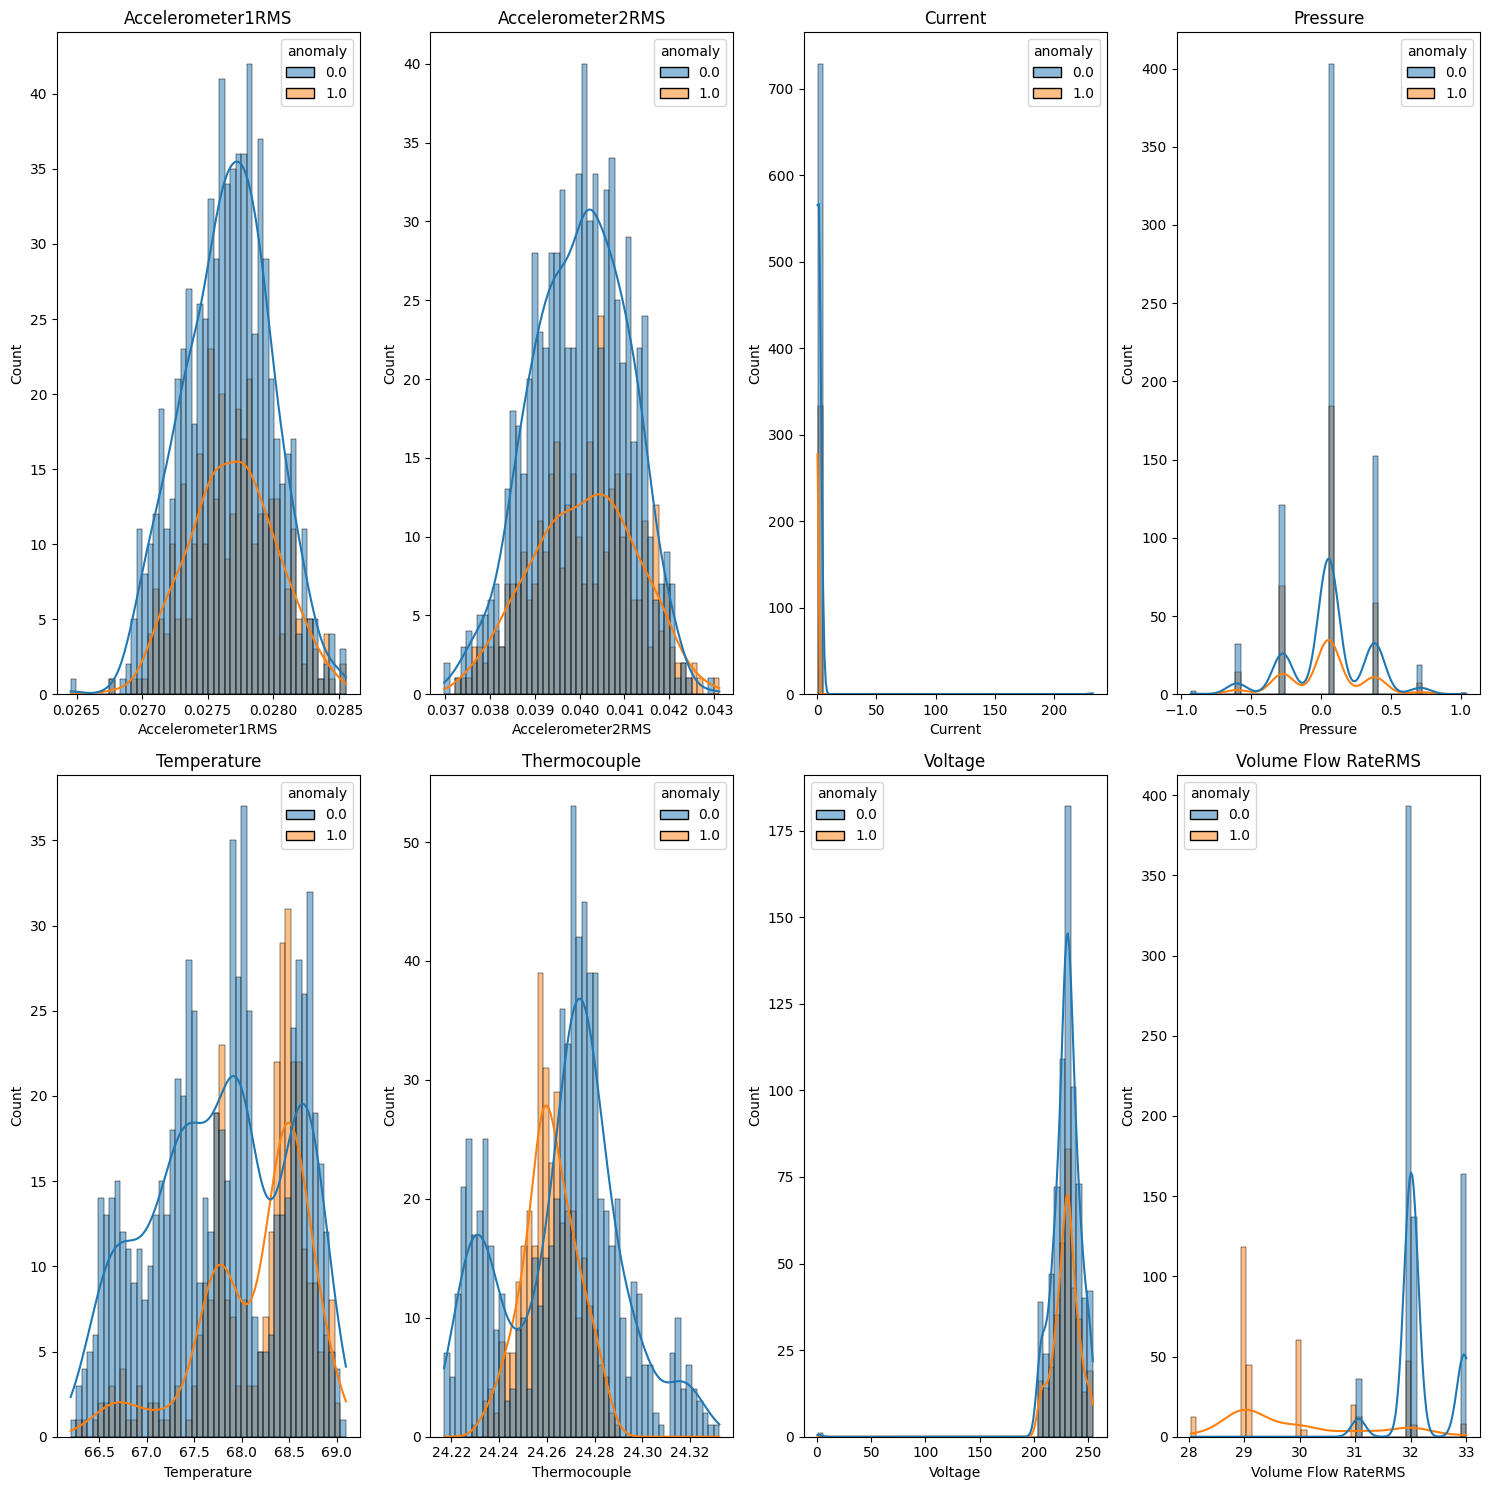

In [54]:
# Accelerometer1RMS Trend analysis, 시각화를 통해 데이터를 구분해서 함께 그려보기
plt.figure(figsize=(15,15))
for i in range(len(data.columns[:-2])):
    plt.subplot(2, 4, i+1)
    sns.histplot(data=data, x=data.columns[i], kde=True, hue='anomaly', bins=50)
    plt.title(data.columns[i])
plt.tight_layout()
plt.show()

In [ ]:
data.iloc[:-2].plot(backend='plotly')

In [101]:
df_resample = data.resample('1s').mean()
df_resample.plot(backend='plotly')

In [102]:
len(df), len(df_resample)

(1063, 1201)

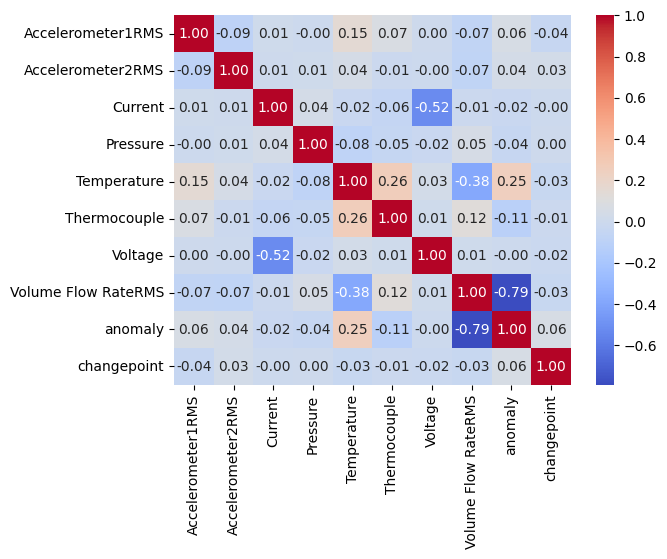

In [64]:
plt.figure()
sns.heatmap(data=data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.show()

<Figure size 640x480 with 0 Axes>

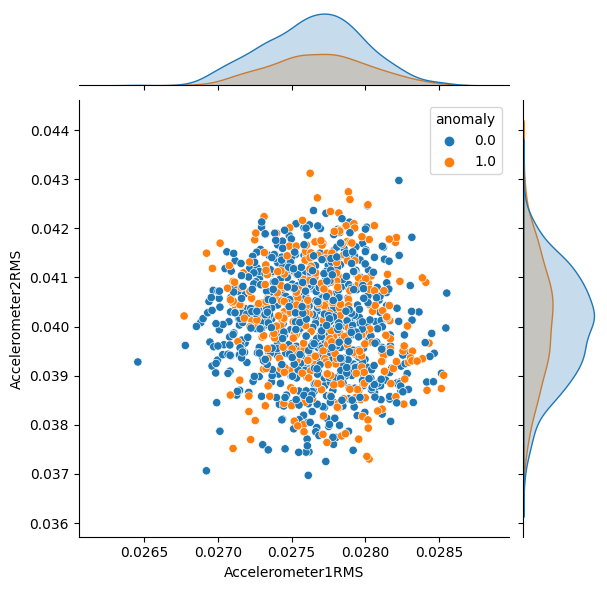

In [57]:
plt.figure()
sns.jointplot(data=data, x='Accelerometer1RMS', y='Accelerometer2RMS', hue='anomaly')
plt.show()

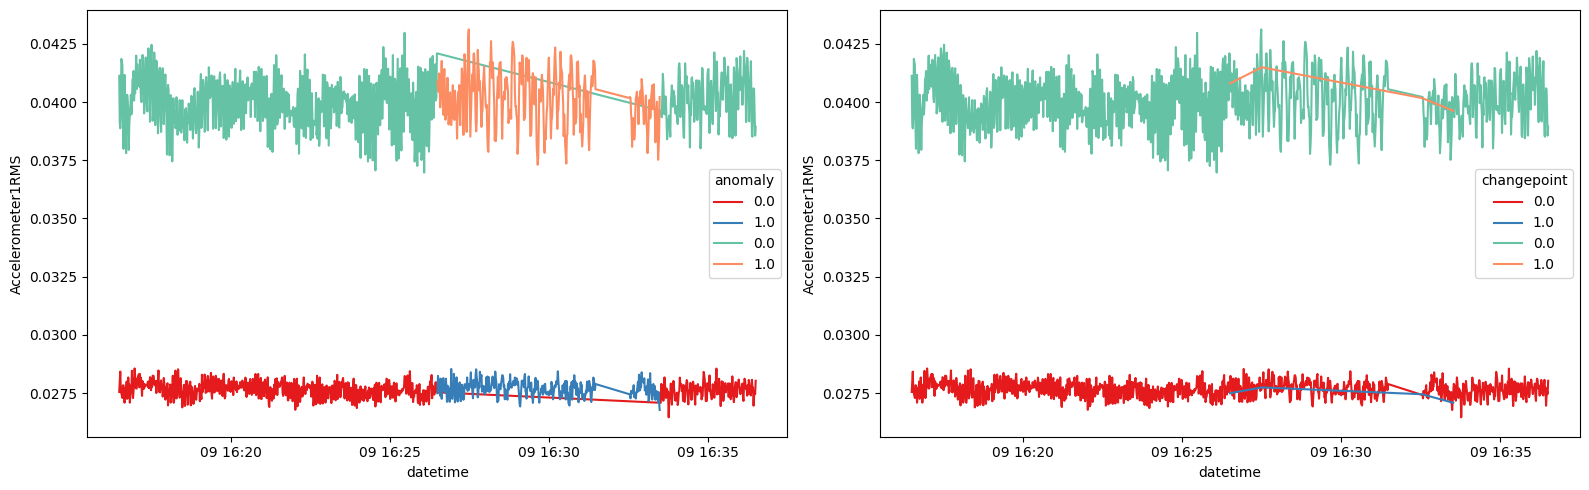

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.lineplot(data=data, x=data.index, y='Accelerometer1RMS', palette='Set1', hue='anomaly', ax=ax[0])
sns.lineplot(data=data, x=data.index, y='Accelerometer2RMS', palette='Set2', hue='anomaly', ax=ax[0])
sns.lineplot(data=data, x=data.index, y='Accelerometer1RMS', palette='Set1', hue='changepoint', ax=ax[1])
sns.lineplot(data=data, x=data.index, y='Accelerometer2RMS', palette='Set2', hue='changepoint', ax=ax[1])
plt.tight_layout()
plt.show()

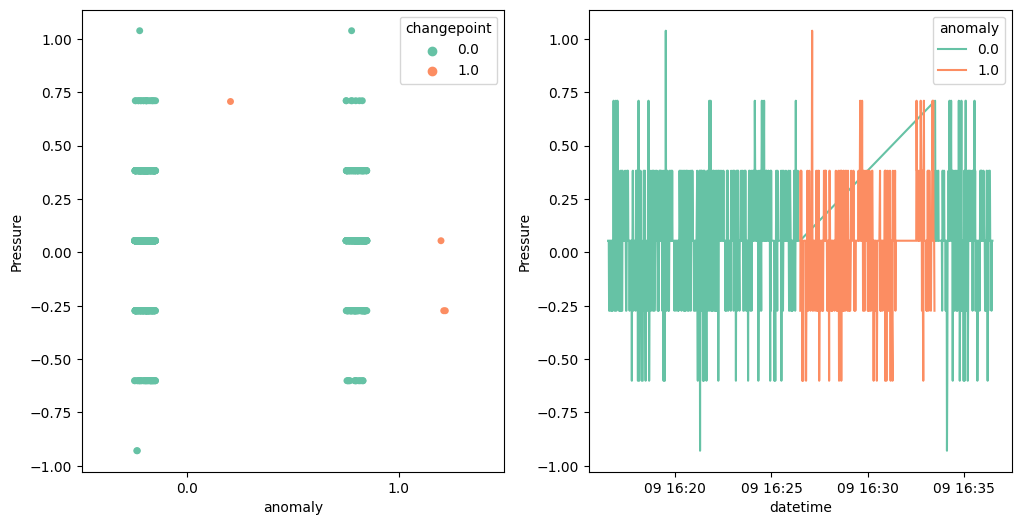

In [72]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.stripplot(data=data, x='anomaly', y='Pressure', jitter=True, hue='changepoint', palette='Set2', dodge=True, ax=ax[0])
sns.lineplot(data=data, x=data.index, y='Pressure', ax=ax[1], hue='anomaly', palette='Set2')
plt.show()

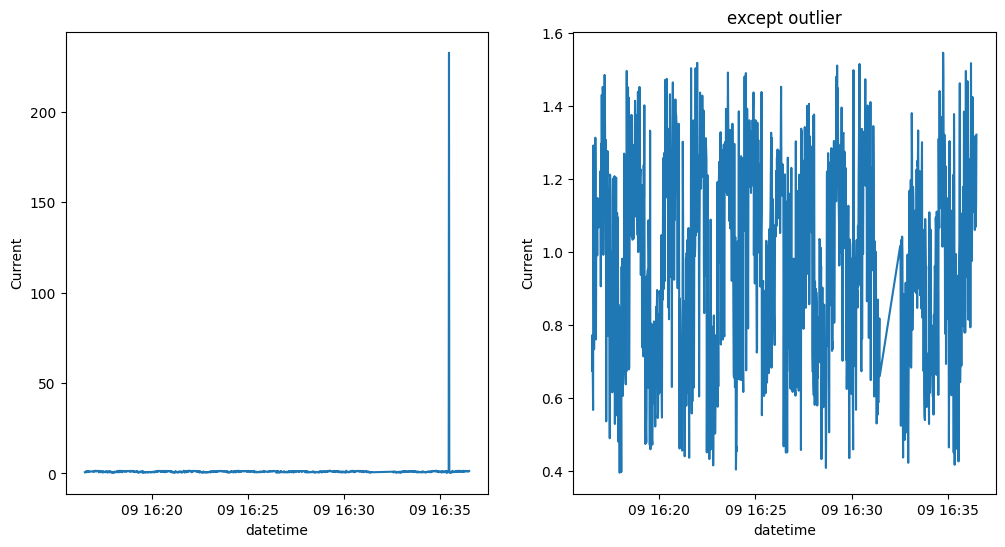

In [103]:
# 원본과 이상치 제거한 것과의 비교
tmp = data[data['Current'] < 100]
tmp_idx = data[data['Current'] < 100].index

fig, ax = plt.subplots(1,2, figsize=(12,6))
sns.lineplot(data=data, x=data.index, y='Current', ax=ax[0])
sns.lineplot(data=tmp, x=tmp.index, y='Current', ax=ax[1])
ax[1].set_title('except outlier')
plt.show()

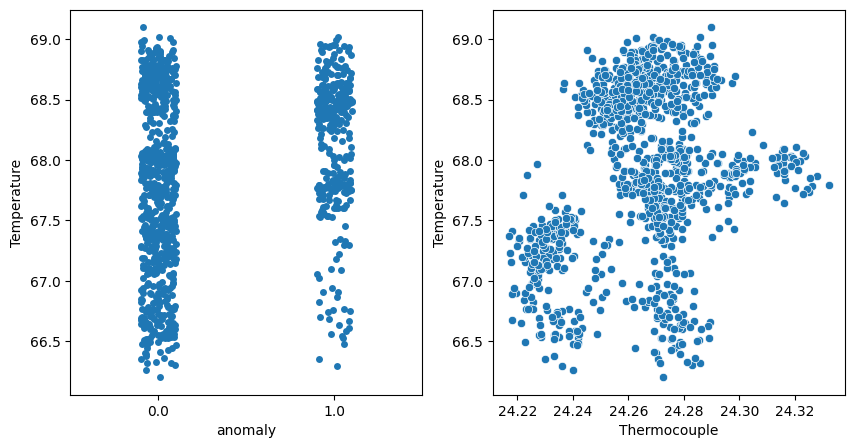

In [110]:
fig, ax = plt.subplots(1,2 ,figsize=(10, 5))
sns.stripplot(data=data, x='anomaly', y='Temperature', jitter=True, dodge=True, ax=ax[0])
sns.scatterplot(data=data, x='Thermocouple', y='Temperature', ax=ax[1])
plt.show()

## 시계열 센서 데이터 분석

* 시계열 센서 데이터 시각화 및 이상(abnormal) 데이터 탐색
* Contextual Anomaly Detection vs Point Anomaly Detection

### 센서별 시각화 (Time-series)
---
- 시계열 센서 데이터는 시간순서에 따른 데이터이므로 시각화 필수
- plt.plot() 활용

In [ ]:
# 시각화를 통해 각 센서데이터에서 anomaly에 영향을 주는 컬럼(feature)을 확인해보자.

### 센서별 분포 (Distribution)
---
- 각 센서데이터의 분포를 보고 분류가능한지 확인해볼려고
- seaborn.displot() 활용

### 상관관계 분석 (Correlation)
---
- 상관관계분석을 통해 anomaly, normal 데이터의 분류 가능성 확인
- corr(), heatmap() 활용

## 이상탐지 모델링
- isolation

### Model Selection
---
- 변수의 시간에 따른 이상탐지 보다는 변수간 관계에 따른 이상탐지 수행 필요

* Isolation Forest - 기본적으로 사용했으면 합니다. 성능이 괜찮아요. 
* 추가로 어떤 이상탐지 알고리즘을 써보세요

### 모델링을 위한 데이터 준비
---
* 모델링을 수행하기 위해 Feature(X)와 예측하고자하는 값인 y로 데이터를 나눔
* 학습과 예측을 위한 Train / Test set 분할
* Train/Test 분할시 anomaly 데이터가 일정하게 포함되도록 하는 것이 필수, 확인도 필요

### 모델 학습 및 평가
---
- IsolationForest
- 성능평가(과적합되는지도 확인해보세요)
- 성능중에서 무엇을 중점적으로 보아야 할까요? Accuracty(정확도), Precision(정밀도), Recall(재현율) ? 
- sklearn.metrics의 classification_report() 활용

### Scoring 기반 Threshold 조정
---
- IsolationForest에는 decision_function()이라는 스코어를 보여주는 것이 있습니다. 이를 활용해보세요.
- 분포시각화를 통해 Threshold 조정 해보세요. 스코어기반 threshold를 변경한 후 성능평가 해보세요
- sklearn.metrics의 classification_report() 활용